# A Gentle Introduction to Continual Learning in PyTorch

In this brief tutorial we will learn the basics of *Continual Learning* using *PyTorch*. We will use the standard MNIST, SVHN, FashionMNIST benchmark so that you can swiftly run this notebook from anywhere!

We will start with learning over the standard *MNIST* benchmark, then we will move in the actual continual learning setting  with the *Permuted MNIST* benchmark. Let's have some fun! :-)




## Google Colaboratory

First of all, take a moment to look around and discover Google Colab if you haven't before! You can run the commands below to understand how much resources you're using and are still available. Then consider also that you can also connect your Google Drive for additional space or for easily loading your own files.

You can always reset the entire VM with "*Runtime > Reset all runtime*" in case of difficulty. Make also sure you're using the GPU or TPU in the same  tab ("*Runtime > Change runtime type*").

In [1]:
!free -m
!df -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:          12991         560       10125           1        2304       12163
Swap:             0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   47G   32G  60% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  821M  59% /sbin/docker-init
tmpfs           6.4G   28K  6.4G   1% /var/colab
/dev/sda1        86G   51G   35G  60% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
Fri Oct 22 05:42:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+------

In [2]:
import torch
torch.cuda.is_available()

True

That's great, let us import then a few libraries, which we'll be using during this tutorial!

In [3]:
import torch
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import tqdm
import random
import matplotlib.pyplot as plt

## MNIST: Digits recognition with PyTorch 

All right, let's start then making sure we all know the basics! Let's recognize the ten handwritten digits learning from 60.000, 28x28 grayscale images.

In [4]:
mnist_train = datasets.MNIST('mnist', train=True, download=True,
                             transform=transforms.Compose([lambda x: x.convert('RGB'),
                                                           transforms.ToTensor()]))

mnist_test = datasets.MNIST('mnist', train=False, download=True,
                            transform=transforms.Compose([lambda x: x.convert('RGB'),
                                                           transforms.ToTensor()]))

mnist_train_dataloader = DataLoader(mnist_train, batch_size=256, shuffle=True, drop_last=True)
mnist_test_dataloader = DataLoader(mnist_test, batch_size=256, shuffle=False, drop_last=False)

x_train, y_train = next(iter(mnist_train_dataloader))
x_test, y_test = next(iter(mnist_test_dataloader))

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", y_train.shape, y_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", y_test.shape, y_test.dtype)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


x_train dim and type:  torch.Size([256, 3, 28, 28]) torch.float32
t_train dim and type:  torch.Size([256]) torch.int64
x_test dim and type:  torch.Size([256, 3, 28, 28]) torch.float32
t_test dim and type:  torch.Size([256]) torch.int64


Let's take a look at the actual images!

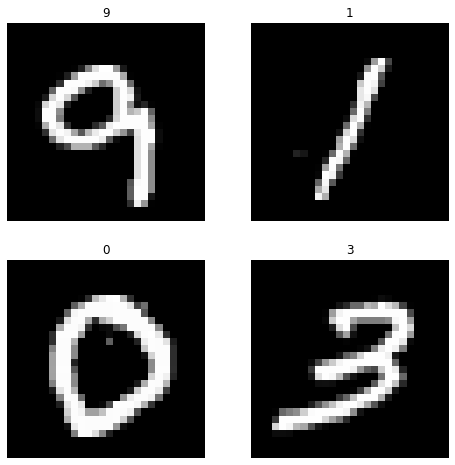

In [5]:
toPIL = transforms.ToPILImage()

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1); plt.imshow(toPIL(x_train[0])); plt.title(y_train[0].item()); plt.axis('off')
plt.subplot(2, 2, 2); plt.imshow(toPIL(x_train[1])); plt.title(y_train[1].item()); plt.axis('off')
plt.subplot(2, 2, 3); plt.imshow(toPIL(x_train[2])); plt.title(y_train[2].item()); plt.axis('off')
plt.subplot(2, 2, 4); plt.imshow(toPIL(x_train[3])); plt.title(y_train[3].item()); plt.axis('off')
plt.show()

Good! Let's now set up a few general setting before using torch...

In [6]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");

... and define our first conv-net! We will use 2 layers of convolutions and two fully connected layers:

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*5*5, 320)
        self.fc2 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

Then we can write the *train* and *test* functions. 

In [8]:
def train(model, device, dataloader, optimizer, epoch):
    model.train()
    
    for x, y in tqdm.notebook.tqdm(dataloader, desc='train', leave=False):
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()

def test(model, device, dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    ns = 0
    for x, y in tqdm.notebook.tqdm(dataloader, desc='test', leave=False):
      with torch.no_grad():
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y) # (#batch, #classes)
        pred = torch.argmax(output, dim=1)
        correct += torch.sum(pred == y)
        ns += len(y)

    test_loss /= ns
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, ns,
        100. * correct / ns))
    return 100. * correct / ns

Then we are ready to instantiate our model and start the training!

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
for epoch in range(2):
  train(model, device, mnist_train_dataloader, optimizer, epoch)
  test(model, device, mnist_test_dataloader)

train:   0%|          | 0/234 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0008, Accuracy: 9413/10000 (94%)



train:   0%|          | 0/234 [00:00<?, ?it/s]

test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0004, Accuracy: 9735/10000 (97%)



Wow! 95% accuracy in such a short time. 

**Questions to explore:**

*   Can you find a better parametrization to improve the final accuracy?
*   Can you change the network architecture to improve the final accuracy?
*   Can you achieve the same performances with a smaller architecture?
*   What's the difference in accuracy if you change convolutions with fully connected layers?

But what if now we want the same model being able to solve a new task we encounter over time like a SVHN?

In [11]:
svhn_train = datasets.SVHN('svhn', split='train', download=True,
                           transform=transforms.Compose([transforms.Resize((28, 28)), 
                                                         transforms.ToTensor()]))
svhn_test = datasets.SVHN('svhn', split='test', download=True,
                          transform=transforms.Compose([transforms.Resize((28, 28)), 
                                                         transforms.ToTensor()]))

svhn_train_dataloader = DataLoader(svhn_train, batch_size=256, shuffle=True, drop_last=True)
svhn_test_dataloader = DataLoader(svhn_test, batch_size=256, shuffle=False, drop_last=False)

x_train, y_train = next(iter(svhn_train_dataloader))
x_test, y_test = next(iter(svhn_test_dataloader))

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", y_train.shape, y_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", y_test.shape, y_test.dtype)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

x_train dim and type:  torch.Size([256, 3, 28, 28]) torch.float32
t_train dim and type:  torch.Size([256]) torch.int64
x_test dim and type:  torch.Size([256, 3, 28, 28]) torch.float32
t_test dim and type:  torch.Size([256]) torch.int64


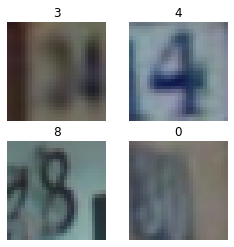

In [12]:
toPIL = transforms.ToPILImage()

plt.figure(figsize=(4,4))
plt.subplot(2, 2, 1); plt.imshow(toPIL(x_train[0])); plt.title(y_train[0].item()); plt.axis('off')
plt.subplot(2, 2, 2); plt.imshow(toPIL(x_train[1])); plt.title(y_train[1].item()); plt.axis('off')
plt.subplot(2, 2, 3); plt.imshow(toPIL(x_train[2])); plt.title(y_train[2].item()); plt.axis('off')
plt.subplot(2, 2, 4); plt.imshow(toPIL(x_train[3])); plt.title(y_train[3].item()); plt.axis('off')
plt.show()

Amazing. Now let's see how our pre-trained model is working on both the original and the SVHN dataset:

In [13]:
print("Testing on the first task:")
test(model, device, mnist_test_dataloader)

print("Testing on the second task:")
test(model, device, svhn_test_dataloader);

Testing on the first task:


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0004, Accuracy: 9735/10000 (97%)

Testing on the second task:


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0109, Accuracy: 3403/26032 (13%)



Mmmh... that's pretty bad, our model cannot generalize to this apparently very different new task! Well, we can just finetune our model using the new permuted training set!

In [14]:
for epoch in range(2):
  train(model, device, svhn_train_dataloader, optimizer, epoch)
  test(model, device, svhn_test_dataloader)

train:   0%|          | 0/286 [00:00<?, ?it/s]

test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 20445/26032 (79%)



train:   0%|          | 0/286 [00:00<?, ?it/s]

test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0025, Accuracy: 21319/26032 (82%)



In [15]:
print("Testing on the first task:")
test(model, device, mnist_test_dataloader)

print("Testing on the second task:")
test(model, device, svhn_test_dataloader)

Testing on the first task:


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0108, Accuracy: 6566/10000 (66%)

Testing on the second task:


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0025, Accuracy: 21319/26032 (82%)



tensor(81.8954, device='cuda:0')

This is very annoying! Now we are not able to solve the original MNSIT task anymore! :-( This is the phenomenon known in literature as **Catastrophic Forgetting**! In the following section we well compare three different strategies for learning continually (and trying to not forget!)

## CL Strategies

Let us now focus on some strategies for reducing catastrofic forgetting, one of the principal problems when learning continuously. in this section we will take a look at three different strategies:

1.   Naive
2.   Rehearsal
3.   Elastic Weight Consolidation (EWC)

Finally we will plot our results for comparison. For a more comprehensive overview on recent CL strategies for deep learning take a look at the recent paper "[Continuous Learning in Single-Incremental-Task Scenarios](https://arxiv.org/abs/1806.08568)".



In [16]:
transform = transforms.Compose([lambda x: x.convert('RGB'),
                                transforms.Resize((28, 28)),
                                transforms.ToTensor()])

mnist_train = datasets.MNIST('mnist', train=True, download=True,
                             transform=transform)
mnist_test = datasets.MNIST('mnist', train=False, download=True,
                            transform=transform)

svhn_train = datasets.SVHN('svhn', split='train', download=True,
                           transform=transform)
svhn_test = datasets.SVHN('svhn', split='test', download=True,
                          transform=transform)

fashion_mnist_train = datasets.FashionMNIST('fashion_mnist', train=True, download=True,
                                           transform=transform)
fashion_mnist_test = datasets.FashionMNIST('fashion_mnist', train=False, download=True,
                                           transform=transform)


train_tasks = [mnist_train, svhn_train, fashion_mnist_train]
test_tasks = [mnist_test, svhn_test, fashion_mnist_test]

Using downloaded and verified file: svhn/train_32x32.mat
Using downloaded and verified file: svhn/test_32x32.mat


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



### Naive Strategy

The  *Naive* strategy, is the simple idea of continuing the back-prop process on the new batches/tasks. This is very simple, but at the same time very prone to forgetting as we have witnessed before. Let's how it works on three tasks:

In [17]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [18]:
naive_accs = []

for id in range(len(train_tasks)):
  avg_acc = 0
  print("Training on task: ", id)

  train_dataloader = DataLoader(train_tasks[id], batch_size=256, shuffle=True, drop_last=True)
  
  for epoch in range(2):
    train(model, device, train_dataloader, optimizer, epoch)
    
  for id_test in range(len(train_tasks)):
    print("Testing on task: ", id_test)

    test_dataloader = DataLoader(test_tasks[id_test], batch_size=256, shuffle=False, drop_last=False)
    acc = test(model, device, test_dataloader)
    avg_acc = avg_acc + acc 
  
  naive_accs.append(avg_acc / (len(train_tasks)))
  print("Avg acc: ", avg_acc / (len(train_tasks)))
  print('=====================================================================')

Training on task:  0


train:   0%|          | 0/234 [00:00<?, ?it/s]

train:   0%|          | 0/234 [00:00<?, ?it/s]

Testing on task:  0


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0003, Accuracy: 9720/10000 (97%)

Testing on task:  1


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0116, Accuracy: 2909/26032 (11%)

Testing on task:  2


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0189, Accuracy: 555/10000 (6%)

Avg acc:  tensor(37.9749, device='cuda:0')
Training on task:  1


train:   0%|          | 0/286 [00:00<?, ?it/s]

train:   0%|          | 0/286 [00:00<?, ?it/s]

Testing on task:  0


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0112, Accuracy: 6650/10000 (66%)

Testing on task:  1


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0025, Accuracy: 21478/26032 (83%)

Testing on task:  2


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0277, Accuracy: 979/10000 (10%)

Avg acc:  tensor(52.9320, device='cuda:0')
Training on task:  2


train:   0%|          | 0/234 [00:00<?, ?it/s]

train:   0%|          | 0/234 [00:00<?, ?it/s]

Testing on task:  0


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0180, Accuracy: 1738/10000 (17%)

Testing on task:  1


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0104, Accuracy: 3353/26032 (13%)

Testing on task:  2


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0017, Accuracy: 8405/10000 (84%)

Avg acc:  tensor(38.1034, device='cuda:0')


### Rehearsal Strategy

Another simple CL idea is to carry on *all* or *part* of the previously encountered examples (of the previous tasks), shuffling them with the data of the current task. Using *all* the past data is near to the optimal performance we can desire at the end of the task sequence but at the expense of much bigger memory usage.

Let's start by defining a function to shuffle our data:



Now we can reset the model and optimizer and run our training over the tasks sequence:

In [19]:
BUFFER_SIZE = 50000
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [20]:
rehe_accs = []
for id in range(len(train_tasks)):
  avg_acc = 0
  print("Training on task: ", id)
  
  # merge examples from previous task
  if id > 0:
    prevs = []
    for i in range(id):
      prevs.append(Subset(train_tasks[i], list(range(BUFFER_SIZE // id))))

    train_dataset = ConcatDataset(prevs + [train_tasks[id]])
  else:
    train_dataset = train_tasks[id]

  train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)

  for epoch in range(2):
    train(model, device, train_dataloader, optimizer, epoch)
    
  for id_test in range(len(train_tasks)):
    print("Testing on task: ", id_test)

    test_dataloader = DataLoader(test_tasks[id_test], batch_size=256, shuffle=False, drop_last=False)
    acc = test(model, device, test_dataloader)
    avg_acc = avg_acc + acc 
  
  rehe_accs.append(avg_acc / (len(train_tasks)))
  print("Avg acc: ", avg_acc / (len(train_tasks)))
  print('=====================================================================')

Training on task:  0


train:   0%|          | 0/234 [00:00<?, ?it/s]

train:   0%|          | 0/234 [00:00<?, ?it/s]

Testing on task:  0


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0004, Accuracy: 9689/10000 (97%)

Testing on task:  1


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0116, Accuracy: 2947/26032 (11%)

Testing on task:  2


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0207, Accuracy: 515/10000 (5%)

Avg acc:  tensor(37.7869, device='cuda:0')
Training on task:  1


train:   0%|          | 0/481 [00:00<?, ?it/s]

train:   0%|          | 0/481 [00:00<?, ?it/s]

Testing on task:  0


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0003, Accuracy: 9765/10000 (98%)

Testing on task:  1


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0025, Accuracy: 21479/26032 (83%)

Testing on task:  2


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0259, Accuracy: 642/10000 (6%)

Avg acc:  tensor(62.1933, device='cuda:0')
Training on task:  2


train:   0%|          | 0/429 [00:00<?, ?it/s]

train:   0%|          | 0/429 [00:00<?, ?it/s]

Testing on task:  0


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0003, Accuracy: 9764/10000 (98%)

Testing on task:  1


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0026, Accuracy: 21322/26032 (82%)

Testing on task:  2


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0018, Accuracy: 8455/10000 (85%)

Avg acc:  tensor(88.0323, device='cuda:0')


### Elastic Weights Consolidation (EWC) Strategy

Elastic Weights Consolidation (EWC) is a common CL strategy firstly proposed in the paper: "[Overcoming catastrophic forgetting in neural networks](https://arxiv.org/abs/1612.00796)" for deep neural networks.

It is based on the computation of the importance of each weight (fisher information) and a squared regularization loss, penalizing changes in the most important wheights for the previous tasks.

It has the great advantage of **not using any** of the previous tasks data!

In [21]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.1

In [22]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Now we need to define an additional function to compute the fisher information for each weight at the end of each task:

In [23]:
def on_task_update(task_id, dataloader):

  model.train()
  
  # accumulating gradients
  for x, y in dataloader:
      optimizer.zero_grad()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():
    
    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

We need also to modify our *train* function to add the new regularization loss:

In [24]:
def train_ewc(model, device, task_id, dataloader, optimizer, epoch):
    model.train()

    for x, y in tqdm.notebook.tqdm(dataloader, desc='train', leave=False):
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      
      ewc_loss = 0
      ### magic here! :-)
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          ewc_loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda

      loss = loss + ewc_loss
      loss.backward()
      optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [25]:
ewc_accs = []

for id in range(len(train_tasks)):
  avg_acc = 0
  print("Training on task: ", id)
  
  train_dataloader = DataLoader(train_tasks[id], batch_size=256, shuffle=True, drop_last=True)
  
  for epoch in range(2):
    train_ewc(model, device, id, train_dataloader, optimizer, epoch)
  on_task_update(id, train_dataloader)
    
  for id_test in range(len(train_tasks)):
    print("Testing on task: ", id_test)

    test_dataloader = DataLoader(test_tasks[id_test], batch_size=256, shuffle=False, drop_last=False)
    acc = test(model, device, test_dataloader)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / (len(train_tasks)))
  ewc_accs.append(avg_acc / (len(train_tasks)))

Training on task:  0


train:   0%|          | 0/234 [00:00<?, ?it/s]

Train Epoch: 0 	Loss: 0.329469


train:   0%|          | 0/234 [00:00<?, ?it/s]

Train Epoch: 1 	Loss: 0.152624
Testing on task:  0


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0004, Accuracy: 9662/10000 (97%)

Testing on task:  1


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0129, Accuracy: 2719/26032 (10%)

Testing on task:  2


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0219, Accuracy: 516/10000 (5%)

Avg acc:  tensor(37.4083, device='cuda:0')
Training on task:  1


train:   0%|          | 0/286 [00:00<?, ?it/s]

Train Epoch: 0 	Loss: 1.006211


train:   0%|          | 0/286 [00:00<?, ?it/s]

Train Epoch: 1 	Loss: 0.722063
Testing on task:  0


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0112, Accuracy: 6325/10000 (63%)

Testing on task:  1


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0025, Accuracy: 21280/26032 (82%)

Testing on task:  2


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0259, Accuracy: 1110/10000 (11%)

Avg acc:  tensor(52.0319, device='cuda:0')
Training on task:  2


train:   0%|          | 0/234 [00:00<?, ?it/s]

Train Epoch: 0 	Loss: 0.591195


train:   0%|          | 0/234 [00:00<?, ?it/s]

Train Epoch: 1 	Loss: 0.514997
Testing on task:  0


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0167, Accuracy: 1811/10000 (18%)

Testing on task:  1


test:   0%|          | 0/102 [00:00<?, ?it/s]

Test set: Average loss: 0.0092, Accuracy: 4742/26032 (18%)

Testing on task:  2


test:   0%|          | 0/40 [00:00<?, ?it/s]

Test set: Average loss: 0.0018, Accuracy: 8258/10000 (83%)

Avg acc:  tensor(39.6353, device='cuda:0')


**Questions to explore:**

*   How much the `ewc_lambda` parameter effect the final results? 
*   Can you find a better parametrization to improve stability?
*   Can you find the memory overhead introduced by EWC with respect to the Naive approach?

Some tips here: https://arxiv.org/pdf/1805.06370.pdf

### Plot Results

To conclude, let's summerize our results in a nice plot! :-)

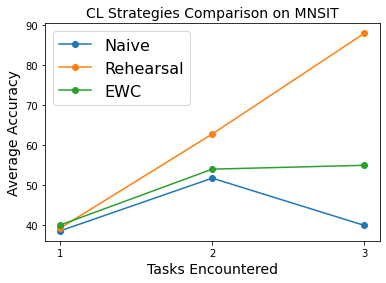

In [ ]:
plt.plot([1, 2, 3], naive_accs, '-o', label="Naive")
plt.plot([1, 2, 3], rehe_accs, '-o', label="Rehearsal")
plt.plot([1, 2, 3], ewc_accs, '-o', label="EWC")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies Comparison on MNSIT', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});